#### Learning of Structured Data - Portfolio  3
---
*Group 1* - CNN1D approach

Contributor: Fikrat Mutallimov

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
to_use = [] # columns to be used. skip the confidence score. and angles
for i in range(0,75,3):
    to_use.append(i)
    to_use.append(i+1)


In [4]:
data_list = []

mapping = {"boxing" :0,
"drums" : 1,
"guitar" : 2,
"rowing" : 3,
"violin" :4}

training_files =  os.listdir('/content/drive/MyDrive/dataset/train/train')

for file in training_files:
    d = pd.read_csv(f'/content/drive/MyDrive/dataset/train/train/{file}',usecols=to_use)
    d = d.fillna(0)
    data_list.append(d.to_numpy()[:int(len(d)/2)]) # remove half of datasets, 'cause they are repeating, but additionally they have angles and confidience score


# labels
labels = []
for name in training_files:
    lab = mapping[name[9:-4]]
    labels.append(lab)

len(data_list),len(labels)

(1167, 1167)

# Train test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_list, labels, test_size=0.33, random_state=42)

# Creating Windows

In [6]:
window_size = 50
stride = 1

#training
tr_windows = []
tr_window_labels = []


for f,l in zip(X_train,y_train):
    #print(f.shape)
    for j in range(f.shape[0]-window_size):
        tr_windows.append(f[j:j+50,:])
        tr_window_labels.append(l)


#validation
te_windows = []
te_window_labels = []


for f,l in zip(X_test,y_test):
    #print(f.shape)
    for j in range(f.shape[0]-window_size):
        te_windows.append(f[j:j+50,:])
        te_window_labels.append(l)


len(tr_windows),len(tr_window_labels),len(te_windows),len(te_window_labels)

(177032, 177032, 90162, 90162)

In [7]:
tr_windows = torch.tensor(np.array(tr_windows)).permute(0,2,1)    # CNN1D input shape ----> N,C,L  C=75, L= window_size
tr_window_labels = torch.tensor(np.array(tr_window_labels))

te_windows = torch.tensor(np.array(te_windows)).permute(0,2,1)
te_window_labels = torch.tensor(np.array(te_window_labels))


tr_windows.shape,tr_window_labels.shape,te_windows.shape,te_window_labels.shape

(torch.Size([177032, 50, 50]),
 torch.Size([177032]),
 torch.Size([90162, 50, 50]),
 torch.Size([90162]))

# CNN1D model

In [8]:
import torch
import torch.nn as nn

class SimpleCNN1DModel(nn.Module):
    def __init__(self, num_channels, window_size):
        super(SimpleCNN1DModel, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(num_channels, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

        # Calculate the final size after two CNN layers and pooling
        final_size = window_size // 2 // 2

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * final_size, 64),
            nn.ReLU(),
            nn.Linear(64, 5)  # Assuming a regression task, change as needed
        )

    def forward(self, x):
        x = self.model(x)

        # Reshape for fully connected layer
        x = x.view(x.size(0), -1)

        x = self.fc_layers(x)
        return x

# Example instantiation with 50 channels and window size of 50
num_channels = 50
model = SimpleCNN1DModel(num_channels=num_channels, window_size=window_size)

# Print the model architecture
print(model)


SimpleCNN1DModel(
  (model): Sequential(
    (0): Conv1d(50, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=384, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=5, bias=True)
  )
)


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
l = []
num_epochs = 10
batch_size = 16
for epoch in range(num_epochs):
    model.train()
    indexes = np.random.permutation(tr_windows.shape[0])
    for i in range(0,indexes.shape[0],batch_size):
        #print(i,indexes[i:i+batch_size])
        inputs, lab = tr_windows[[indexes[i:i+batch_size]]].to(device), tr_window_labels[[indexes[i:i+batch_size]]].to(device)
        #print(inputs.shape,labels)
        optimizer.zero_grad()
        outputs = model(inputs.float())
        loss = criterion(outputs, lab.long())
        loss.backward()
        optimizer.step()
        l.append(loss.item())
    print(sum(l)/len(l))

0.04580713440399192
0.04937008416071392
0.05065946804624442
0.050573745018678375
0.05091667085278448
0.051221745414176956
0.051183364011081
0.0515021737026315
0.05180719617216019
0.052394916191833424


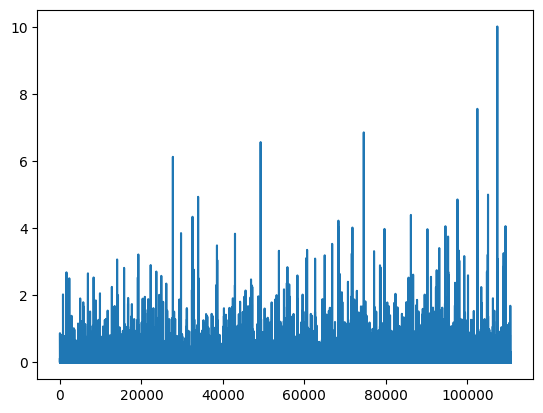

In [12]:
plt.plot(l)

# validation

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, lab in zip(te_windows,te_window_labels):
        inputs, lab = inputs.to(device), lab.to(device)
        #print(lab)
        outputs = model(inputs.reshape((1,50,50)).float())
        _, predicted = torch.max(outputs.data, 1)
        total +=   1
        correct += (predicted == lab).sum().item()

    accuracy = correct / total
    print(f" Validation Accuracy: {accuracy:.4f}")


 Validation Accuracy: 0.9783


# Kaggle predictions

In [14]:
n = 305
stride=window_size
pred = []
for i in range(n):
    clab = []
    file = pd.read_csv(f'/content/drive/MyDrive/dataset/test/test/{i}.csv',usecols=to_use).fillna(0).to_numpy()
    for j in range(0,file.shape[0]-window_size,stride):
        inp = torch.tensor(file[j:j+50]).unsqueeze(0).permute(0,2,1)
        #print(inp.shape)
        out = torch.argmax(model(inp.float()))
        clab.append(out.item())
    unique, counts = np.unique(clab, return_counts=True)
    fpred = unique[counts.argmax()]
    pred.append(fpred)
pred

[2,
 0,
 2,
 1,
 2,
 4,
 4,
 0,
 0,
 2,
 4,
 4,
 1,
 0,
 0,
 4,
 0,
 0,
 4,
 3,
 2,
 3,
 1,
 0,
 0,
 4,
 0,
 3,
 4,
 4,
 4,
 2,
 4,
 3,
 3,
 4,
 0,
 3,
 3,
 4,
 2,
 4,
 0,
 3,
 3,
 0,
 4,
 0,
 4,
 4,
 3,
 3,
 0,
 0,
 1,
 3,
 4,
 4,
 2,
 3,
 4,
 4,
 1,
 1,
 0,
 1,
 1,
 0,
 3,
 0,
 3,
 4,
 3,
 1,
 0,
 4,
 1,
 4,
 0,
 1,
 2,
 3,
 1,
 3,
 2,
 0,
 1,
 0,
 1,
 4,
 0,
 1,
 0,
 0,
 4,
 1,
 3,
 3,
 0,
 4,
 2,
 3,
 3,
 0,
 0,
 4,
 3,
 1,
 0,
 1,
 0,
 3,
 4,
 2,
 1,
 3,
 4,
 3,
 1,
 0,
 4,
 0,
 3,
 0,
 4,
 3,
 1,
 0,
 3,
 4,
 2,
 4,
 1,
 1,
 2,
 4,
 3,
 4,
 0,
 4,
 2,
 1,
 0,
 2,
 0,
 0,
 3,
 4,
 4,
 4,
 4,
 3,
 3,
 4,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 4,
 3,
 4,
 2,
 2,
 4,
 4,
 4,
 1,
 3,
 0,
 1,
 3,
 2,
 2,
 3,
 3,
 3,
 0,
 1,
 4,
 2,
 3,
 4,
 0,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 0,
 3,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 1,
 2,
 1,
 0,
 4,
 4,
 1,
 4,
 1,
 2,
 3,
 0,
 0,
 0,
 2,
 1,
 3,
 0,
 1,
 0,
 4,
 2,
 0,
 0,
 3,
 3,
 4,
 0,
 0,
 0,
 0,
 4,
 4,
 3,
 1,
 4,
 4,
 2,
 3,
 1,
 4,
 0,
 0,
 0,
 2,


In [15]:
dic = {'id':range(305),'action':pred}
df = pd.DataFrame(dic)
df.to_csv('pred.csv',index=False)